# ELE 435/535 Computational Lab 7

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Load MNIST Dataset 

We will be working with the subset of MNIST that was used for HW1 in this HW. The training data contains 10,000 samples of different digits. Let's call it matrix D (of dimension 784 * 10000). The first 1000 columns of D correspond to digit 0 ($D_0$), the next 1000 correspond to digit 1 ($D_1$), etc. 

In [119]:
train_data = np.load('MNISTcwtrain1000.npy')
train_data = train_data.astype(dtype='float64')
test_data = np.load('MNISTcwtest100.npy')
test_data = test_data.astype(dtype='float64')

train_data = train_data/255.0
test_data = test_data/255.0

In [4]:
train_data.shape

(784, 10000)

In [5]:
test_data.shape

(784, 1000)

### Q1) Collaborative Representation Based Classification Using Lasso

In HW4, we used least square regression for classifiying data. Given any new example (x), we would like to represent it as a linear combination of columns of D (hence, the name representation based classification). This can be acheived by finding a vector w (of dimension 1,000) that satisfies: $w = \arg\min \hspace{1mm} \|Dw - x \|_2$.

The first 100 elements of w ($w_0$) quantify how much of each column from digit 0 are needed to represent x. Similarly, the next 100 elements ($w_1$) correspond to weights on $D_1$, etc.

Next, prediction of pixel values of any test image (x) based only on examples of a particual digit $i$ can be found using $y_i' = D_i \times w_i$. Then, k-th digit that yields the lowest mean squared prediction error (i.e., $k = \arg\min \hspace{1mm} \|y -y'_i \|_2$) will determine the label of x. 

Following this procedure to predict the labels of each test example, the testing accuracy is 0.76.

#### * Use reduced training set ($Xr$) and test set ($test$) defined below. This will save the running time.

In [120]:
Xr=np.zeros((784,1000))
test=np.zeros((784,100))
for ind in range(10):
    Xr[:,100*ind:100*(ind+1)] = train_data[:,1000*ind:1000*ind+100]
    test[:,10*ind:10*(ind+1)] = test_data[:,100*ind:100*ind+10]

In [121]:
# least square
X = np.matrix(Xr)
[U,sigma,V] = np.linalg.svd( X, full_matrices=False)
index = np.where(sigma>1e-4)
trunc = index[0][-1]
INV_Mat = np.linalg.pinv(np.dot(X.T,X))
Projection_Mat = INV_Mat * (X.T) 
predicted_label = np.zeros((100,))
for i in range(0,100):
    test_ex = np.matrix(test[:,i]).T
    p = Projection_Mat * test_ex
    dist = np.zeros((10,))
    for j in range(0,10):
        sub_mat = X[:,j*100:(j+1)*100]
        sub_W = p[j*100:(j+1)*100]
        reconstructed = np.dot(sub_mat, sub_W)
        dist[j] = np.linalg.norm(reconstructed - test_ex)
    predicted_label[i] = np.argmin(dist)
true_label = np.zeros((100,))
for i in range(0,10):
    true_label[i*10:(i+1)*10] = i
test_err = np.count_nonzero(predicted_label - true_label)
test_acc = 1-(test_err/100.0)

print ("Test Accuacy :::::: " + str(test_acc))

Test Accuacy :::::: 0.76


In [5]:
predicted_label

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1., 1., 1., 1., 1., 1., 1.,
       1., 5., 1., 3., 2., 3., 2., 8., 8., 7., 2., 2., 8., 2., 3., 3., 5.,
       3., 9., 3., 3., 3., 3., 4., 4., 4., 4., 4., 6., 9., 4., 4., 4., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 4., 6., 6., 6., 6., 0., 6., 4.,
       6., 6., 7., 7., 1., 7., 7., 7., 7., 7., 6., 7., 2., 8., 8., 8., 8.,
       9., 9., 8., 8., 8., 8., 9., 9., 9., 9., 9., 9., 7., 9., 4.])

In [42]:
Projection_Mat.shape

(1000, 784)

Now, instead of using least square, we use LASSO in this question to find a sparse $w$. The idea behind is that we only want to use a small number of training samples to represent the test sample. Then, the objective is to find a vector $w$ that satisfies: $w = \arg\min \hspace{2mm} \|Dw - x \|_2 ^2 + \lambda \|w \|_1$. 

1.Try $\lambda = 10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}, 1, 10, 100$ and plot testing accuracy vs. $\lambda$. Compare the testing accuracy with that from least square. 

You can use the Lasso solver in Scikit-learn (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html). Note that the objective function of Lasso solver in Scikit-learn might be different from what we defined here. Please adjust your arguments to the solver accordingly.

In [122]:
from sklearn import linear_model


In [104]:
num_examples = Xr.shape[1]
lamda = [1e-5,1e-4,1e-3,1e-2,1e-1, 1, 10, 100]
# lasso = linear_model.Lasso(alpha=10/(2*num_examples))

In [105]:
lamda

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

In [106]:
test.shape

(784, 100)

In [107]:
# LASSO square
# X = np.matrix(Xr)
test_accuracy = np.zeros((1,len(lamda)))
non_zero_vs_lambda =  np.zeros((1,len(lamda)))
for k,lmd in enumerate(lamda):
    lasso = linear_model.Lasso(alpha=lmd/(2*num_examples))
    predicted_label = np.zeros((100,))
    for i in range(0,100):
        test_ex = test[:,i]
        dist = np.zeros((10,))
        fitted_model = lasso.fit(X, test_ex)
        non_zeros_w = np.count_nonzero(fitted_model.coef_)
        non_zero_vs_lambda[0,k] = non_zero_vs_lambda[0,k] + non_zeros_w # sum over all the examples
        for j in range(0,10):
            sub_mat = Xr[:,j*100:(j+1)*100]
            sub_W = fitted_model.coef_[j*100:(j+1)*100]
            reconstructed = np.dot(sub_mat, sub_W )
            dist[j] = np.linalg.norm(reconstructed - test_ex)
        predicted_label[i] = np.argmin(dist)
    true_label = np.zeros((100,))
    for i in range(0,10):
        true_label[i*10:(i+1)*10] = i
    test_err = np.count_nonzero(predicted_label - true_label)
    test_acc = 1-(test_err/100.0)
    test_accuracy[0,k] = test_acc

    print ("Test Accuacy :::::: " + str(test_acc))

C:\Users\preri\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Test Accuacy :::::: 0.26
Test Accuacy :::::: 0.27
Test Accuacy :::::: 0.27
Test Accuacy :::::: 0.4
Test Accuacy :::::: 0.8
Test Accuacy :::::: 0.9299999999999999
Test Accuacy :::::: 0.92
Test Accuacy :::::: 0.79


In [108]:
lamda

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

In [109]:
lamda_array = np.asarray(lamda)

In [110]:
lamda_array

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [111]:
test_accuracy

array([[0.26, 0.27, 0.27, 0.4 , 0.8 , 0.93, 0.92, 0.79]])

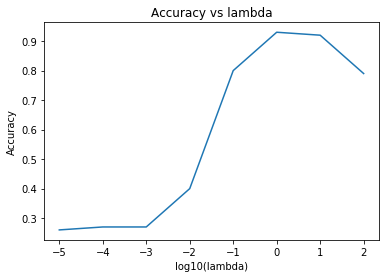

In [113]:
plt.figure()
plt.plot(np.log10(lamda_array),test_accuracy[0])
plt.title('Accuracy vs lambda')
plt.xlabel("log10(lambda)")
plt.ylabel("Accuracy")
plt.show()

### It can be seen that for low values of lamda, the accuracy on the test set is low but as lamda increases to 1, the accuracy peaks to about 0.93 which is higher than accuracy from least squares. This indicates that least squares is likely overfitting on the training data which is not the case when using Lasso as it only selects the most relevant features in the train set.  

2.Plot the average number of nonzero entries in $w$ vs. $\lambda$.

In [114]:
average_non_zero = np.divide(non_zero_vs_lambda,100)
average_non_zero.shape

(1, 8)

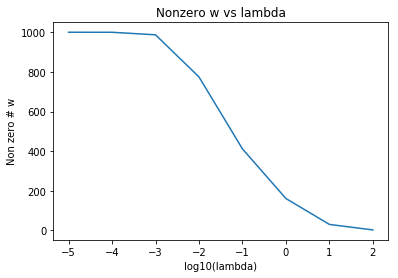

In [115]:
plt.figure()
plt.plot(np.log10(lamda_array),average_non_zero.T)
plt.title('Nonzero w vs lambda')
plt.xlabel("log10(lambda)")
plt.ylabel("Non zero # w")
plt.show()

3.For each test sample, suppose $k$ is the right label, define $nk$ as nonzeros in $w_k$ / total # nonzeros in $w$. Plot the average of $nk$ over all testing samples vs. $\lambda$. What do you find?

In [36]:
# LASSO square
# X = np.matrix(Xr)
test_accuracy = np.zeros((1,len(lamda)))
non_zero_vs_lambda =  np.zeros((1,len(lamda)))
avg_non_zero_for_correct_class =  np.zeros((1,len(lamda)))
for k,lmd in enumerate(lamda):
    lasso = linear_model.Lasso(alpha=lmd/(2*num_examples))
    predicted_label = np.zeros((100,))
    for i in range(0,100):
        test_ex = test[:,i]
        dist = np.zeros((10,))
        fitted_model = lasso.fit(X, test_ex)
        non_zeros_w = np.count_nonzero(fitted_model.coef_)
        non_zero_vs_lambda[0,k] = non_zero_vs_lambda[0,k] + non_zeros_w
        for j in range(0,10):
            sub_mat = Xr[:,j*100:(j+1)*100]
            sub_W = fitted_model.coef_[j*100:(j+1)*100]
            reconstructed = np.dot(sub_mat, sub_W )
            dist[j] = np.linalg.norm(reconstructed - test_ex)
        predicted_label[i] = np.argmin(dist)
        correct_label = np.argmin(dist)
        useful_w_for_correct_label = fitted_model.coef_[correct_label*100:(correct_label+1)*100]
        non_zero_w_for_correct_label = np.count_nonzero(useful_w_for_correct_label)
        ratio_correct_non_zero_total_non_zero = non_zero_w_for_correct_label/(non_zeros_w + 1e-10)
        avg_non_zero_for_correct_class[0,k] = avg_non_zero_for_correct_class[0,k] + ratio_correct_non_zero_total_non_zero
    true_label = np.zeros((100,))
    for i in range(0,10):
        true_label[i*10:(i+1)*10] = i
    test_err = np.count_nonzero(predicted_label - true_label)
    test_acc = 1-(test_err/100.0)
    test_accuracy[0,k] = test_acc

    print ("Test Accuacy :::::: " + str(test_acc))

C:\Users\preri\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Test Accuacy :::::: 0.26
Test Accuacy :::::: 0.27
Test Accuacy :::::: 0.27
Test Accuacy :::::: 0.4
Test Accuacy :::::: 0.8
Test Accuacy :::::: 0.9299999999999999
Test Accuacy :::::: 0.92
Test Accuacy :::::: 0.79


In [39]:
avg_non_zero_for_correct_class_mean_ex = np.divide(avg_non_zero_for_correct_class,100)

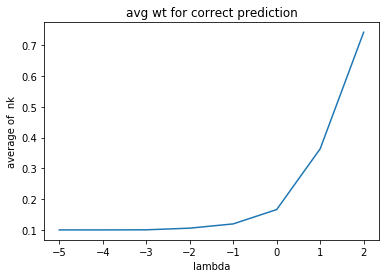

In [132]:
plt.figure()
plt.plot(np.log10(lamda_array),avg_non_zero_for_correct_class_mean_ex.T)
plt.title('avg wt for correct prediction')
plt.xlabel("log10(lambda)")
plt.ylabel("average of  nk")
plt.show()

### As the value of lamda increases, more fraction of the weight is assigned to the correct label. This is expected as increasing the L1 penalty causes a reduction in number of non zero values for w. So, the model puts more weight on the features corresponding to the correct label in comparison to other labels and prevents overfitting.

In [37]:
predicted_label

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1.,
       0., 1., 0., 2., 2., 2., 0., 0., 2., 2., 2., 2., 8., 5., 3., 3., 3.,
       3., 2., 3., 3., 3., 3., 4., 4., 4., 0., 4., 0., 4., 4., 4., 4., 9.,
       5., 5., 5., 5., 5., 0., 5., 5., 5., 6., 6., 6., 6., 0., 6., 6., 6.,
       6., 6., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 2., 8., 8., 8., 8.,
       8., 8., 8., 5., 8., 6., 9., 9., 9., 9., 9., 0., 8., 8., 0.])

### Q2) Collaborative Representation Based Classification Using Elastic Net

We now use the elastic net objective function to find $w$: $w = \arg\min \hspace{2mm} \|Dw - x \|_2 ^2 + \lambda (\alpha \|w \|_1+0.5(1-\alpha) \|w \|_2 ^2 )$. It linearly combines the $L1$ and $L2$ penalties. Choose an appropriate $\lambda$ from Q1, and vary $\alpha$ in the range $(0,1)$.

You can use Scikit-learn ElasticNet (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html). Refer to the documentation on the web.

4.Plot testing accuracy vs. $\alpha$. Compare the testing accuracy with that from least square and Lasso. 

In [123]:
alpha_blend = [.1,.2,.3,.4,.5,.6,.7,.8,.9]

In [124]:
# LASSO square
# X = np.matrix(Xr)
test_accuracy = np.zeros((1,len(alpha_blend)))
non_zero_vs_alpha =  np.zeros((1,len(alpha_blend)))
avg_non_zero_for_correct_class =  np.zeros((1,len(alpha_blend)))
lmd = 1
for k,alph in enumerate(alpha_blend):
#     alpha = (alph*lmd + 0.5*(1-alph)*lmd)/(2*num_examples)
#     l1_ratio = alph/(alph + 0.5*(1-alph))
    alpha = lmd/(2*num_examples)
    l1_ratio = alph
    lasso = linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    predicted_label = np.zeros((100,))
    for i in range(0,100):
        test_ex = test[:,i]
        dist = np.zeros((10,))
        fitted_model = lasso.fit(X, test_ex)
        non_zeros_w = np.count_nonzero(fitted_model.coef_)
        non_zero_vs_alpha[0,k] = non_zero_vs_alpha[0,k] + non_zeros_w
        for j in range(0,10):
            sub_mat = Xr[:,j*100:(j+1)*100]
            sub_W = fitted_model.coef_[j*100:(j+1)*100]
            reconstructed = np.dot(sub_mat, sub_W )
            dist[j] = np.linalg.norm(reconstructed - test_ex)
        predicted_label[i] = np.argmin(dist)
        correct_label = np.argmin(dist)
        useful_w_for_correct_label = fitted_model.coef_[correct_label*100:(correct_label+1)*100]
        non_zero_w_for_correct_label = np.count_nonzero(useful_w_for_correct_label)
        ratio_correct_non_zero_total_non_zero = non_zero_w_for_correct_label/non_zeros_w
        avg_non_zero_for_correct_class[0,k] = avg_non_zero_for_correct_class[0,k] + ratio_correct_non_zero_total_non_zero
    true_label = np.zeros((100,))
    for i in range(0,10):
        true_label[i*10:(i+1)*10] = i
    test_err = np.count_nonzero(predicted_label - true_label)
    test_acc = 1-(test_err/100.0)
    test_accuracy[0,k] = test_acc

    print ("Test Accuacy :::::: " + str(test_acc))

C:\Users\preri\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Test Accuacy :::::: 0.87
Test Accuacy :::::: 0.87
Test Accuacy :::::: 0.9
Test Accuacy :::::: 0.9299999999999999
Test Accuacy :::::: 0.9299999999999999
Test Accuacy :::::: 0.92
Test Accuacy :::::: 0.9299999999999999
Test Accuacy :::::: 0.9299999999999999
Test Accuacy :::::: 0.94


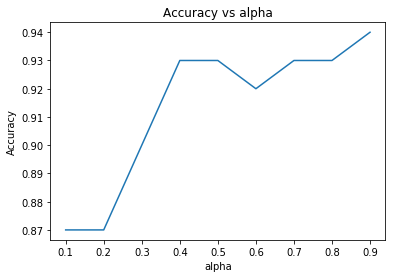

In [125]:
plt.figure()
plt.plot(alpha_blend,test_accuracy[0])
plt.title('Accuracy vs alpha')
plt.xlabel("alpha")
plt.ylabel("Accuracy")
plt.show()

### The best accuracy using elastic net is 0.94 (for alpha = 0.9, lamda = 1) whereas the accuracy using least square was 0.76 and using only lasso with lamda = 1, it was 0.93. This indicates an appropriate balance between L1 and L2 penalty can generalize best to the test data while ensuring we do not overfit on the train data. Least square alone overfits the training data while lasso tries to make components of w to 0. An optimum balance between L1 and L2 penalty helps in learning from the data while ensuring we do not overfit on the training data.

5.Plot the average number of nonzero entries in $w$ vs. $\alpha$ and average $nk$ vs. $\alpha$. What do you find?

In [134]:
non_zero_vs_alpha = np.divide(non_zero_vs_alpha,100)
non_zero_vs_alpha.shape

(1, 9)

In [141]:
average_non_zero_alpha.shape

(1, 11)

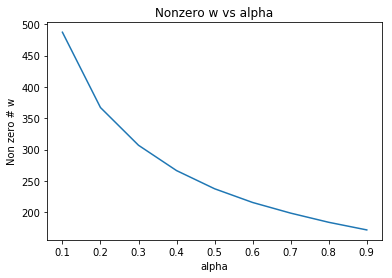

In [135]:
plt.figure()
plt.plot(alpha_blend,non_zero_vs_alpha[0].T)
plt.title('Nonzero w vs alpha')
plt.xlabel("alpha")
plt.ylabel("Non zero # w")
plt.show()

### When alpha is close to 0,  L2 penalty is more dominant as a result of which more weights are non zero. Increasing alpha causes L1 penalty to increase as a result of which nonzero values for w decreases to compensate for L1 penalty. 

In [140]:
avg_non_zero_for_correct_class

array([[11.76339574, 12.67743379, 13.32490911, 14.05938781, 14.54446592,
        14.96943563, 15.51319313, 15.92204651, 16.38798191]])

In [138]:
avg_non_zero_for_correct_class_mean_ex_alpha = np.divide(avg_non_zero_for_correct_class,100)

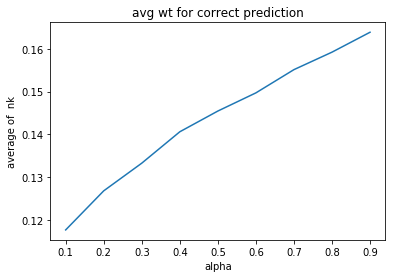

In [139]:
plt.figure()
plt.plot(alpha_blend,avg_non_zero_for_correct_class_mean_ex_alpha.T)
plt.title('avg wt for correct prediction')
plt.xlabel("alpha")
plt.ylabel("average of  nk")
plt.show()

### As expected, for alpha  closer to 0,  L2 penalty terms dominate as a result of which more coefficients of w are non zero. As the number of test cases are same for each class (total classes = 10), for alpha close to 0, the fraction of non zero weights are close to 0.1 (~0.12 in this case). When alpha increases, L1 penalty comes into play which causes more weight being assigned to the correct label than incorrect ones that in turn causes fraction of weight assigned to correct label to increase. It begins to give more importance to weights corresponding to correct label than incorrect ones with increase in alpha.

### Q3) Orthogonal Matching Pursuit (OMP)

The general sparse least squares problem can be posed as below.
\begin{equation}
\min_{x\in\mathbb{R}^n} \|y-Ax\|_2^2
\end{equation}
\begin{equation}
\mbox{s.t.} \|x\|_0 \leq k 
\end{equation}

Orthogonal Matching Pursuit (OMP) is a greedy algorithm for sparse least squares problem above. Here, we are going to use OMP to find a sparse solution for a synthetic dataset. The dataset is defined below:

X (train) : 100 x 512
y (test) : 100 x 1
w (weight) : 512 x 1


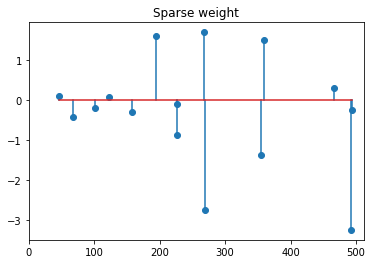

In [54]:
from sklearn import linear_model
from sklearn.datasets import make_sparse_coded_signal

y, X, w = make_sparse_coded_signal(n_samples=1,n_components=512,n_features=100,n_nonzero_coefs=15,random_state=0)
print ('X (train) : ' + str(X.shape[0]) + ' x ' + str(X.shape[1]))
print ('y (test) : ' + str(y.shape[0]) + ' x 1')
print ('w (weight) : ' + str(w.shape[0]) + ' x 1')

idx, = w.nonzero()

plt.figure()
plt.stem(idx, w[idx])
plt.xlim([0,512])
plt.title('Sparse weight')
plt.show()

In [55]:
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV


6.Use the orthogonal matching pursuit algorithm to find the $\hat{w}$ (coefficients) and compare it with the $w$ above (compute $\|w-\hat{w}\|_2^2$). (http://scikit-learn.org/stable/auto_examples/linear_model/plot_omp.html)

You can use scikit-learn OrthogonalMatchingPursuit (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.OrthogonalMatchingPursuit.html). Set $\mbox{n_nonzero_coefs}=20$, $\mbox{fit_intercept}=False$ and default for other parameters. 

C:\Users\preri\Anaconda3\lib\site-packages\sklearn\linear_model\omp.py:385: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)


<StemContainer object of 3 artists>

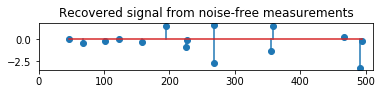

In [56]:
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=20, fit_intercept=False)
omp.fit(X, y)
coef = omp.coef_
idx_r, = coef.nonzero()
plt.subplot(4, 1, 2)
plt.xlim(0, 512)
plt.title("Recovered signal from noise-free measurements")
plt.stem(idx_r, coef[idx_r])

In [57]:
omp.coef_[coef.nonzero()]

array([ 0.09820563, -0.43116899, -0.21079998,  0.07264699, -0.30617707,
        1.58380476, -0.87322229, -0.09824186,  1.68550553, -2.73865906,
       -1.36627127,  1.49132825,  0.30490502, -3.23531439, -0.24061129])

In [58]:
w[w.nonzero()]

array([ 0.09820563, -0.43116899, -0.21079998,  0.07264699, -0.30617707,
        1.58380476, -0.87322229, -0.09824186,  1.68550553, -2.73865906,
       -1.36627127,  1.49132825,  0.30490502, -3.23531439, -0.24061129])

In [59]:
w.nonzero()

(array([ 46,  68, 101, 123, 158, 195, 226, 227, 268, 269, 355, 359, 467,
        492, 494], dtype=int64),)

In [60]:
normed_difference_sq = np.linalg.norm(omp.coef_[coef.nonzero()] - w[w.nonzero()])**2

In [61]:
normed_difference_sq

8.76355902594524e-30

###  $\|w-\hat{w}\|_2^2$ =  8.76355902594524e-30
### This indicates that weight estimates using OMP is close to the sparse weights as defined in the dataset

7.Implement the OMP function yourself with following requirements. 
[Termination conditions]

1)Number of nonzero elements in $w$. 
\begin{equation}
\mbox{number of nonzero elements} = k
\end{equation}
2)Tolerance of the residual.
\begin{equation}
\frac{\|y-\hat{y}\|_2}{\|y\|_2} \leq \mbox{tolerance}
\end{equation}
3)Maximum number of iterations.

In [62]:
# Function outline
def omp(X,y,n_nonzero,tol,max_iter):
    t = 0
    St = []
    rt = y
    terminate = False
    while(not terminate):
        t = t+1
        dot_products = np.abs(np.dot(X.T,rt))
        most_similar_index = np.argmax(dot_products)
        St.append(most_similar_index)
        A_non_zero = X[:,St]
        X_temp = A_non_zero
        INV_Mat = np.linalg.pinv(np.dot(X_temp.T,X_temp))
        Projection_Mat =  np.dot(INV_Mat,X_temp.T)
        wt= np.dot(Projection_Mat,y)
        rt = y - np.dot(A_non_zero,wt)
        toler =  np.linalg.norm(rt)/np.linalg.norm(y)
        if (toler<tol) or (t>max_iter) or np.count_nonzero(wt) >= n_nonzero:
            w = np.zeros(X.shape[1])
            w[St] = wt
            terminate = True    
    return w

8.Repeat question 6 using your OMP function. (Set parameters as $\mbox{n_nonzero}=15$,$\mbox{tol}=10^{-30}$,$\mbox{max_iter}=300$)

In [65]:
tol = 1e-30
max_iter = 300
n_nonzero = 15
wt_my_omp = omp(X,y,n_nonzero,tol,max_iter)
print("My implementation non zero indices")
print(np.nonzero(wt_my_omp))
print("Scipy implementation non zero indices")
print(np.nonzero(w))
print("")
normed_difference_sq = np.linalg.norm(wt_my_omp[wt_my_omp.nonzero()] - w[w.nonzero()])**2
print("Normed difference square")
print(normed_difference_sq)

My implementation non zero indices
(array([ 46,  68, 101, 123, 158, 195, 226, 227, 268, 269, 355, 359, 467,
       492, 494], dtype=int64),)
Scipy implementation non zero indices
(array([ 46,  68, 101, 123, 158, 195, 226, 227, 268, 269, 355, 359, 467,
       492, 494], dtype=int64),)

Normed difference square
1.0388331304928643e-28


### It can be seen that the squared difference of norm using manual implementation of OMP is close to the true sparse weights as defined in the dataset

9.Try changing the tolerance value from $10^{-3}$ to $10^{-30}$ in log scale. 1)Plot the error ($\|w-\hat{w}\|_2^2$) vs. tolerance and 2)number of nonzero elements in $\hat{w}$ vs. tolerance. (Keep $\mbox{n_nonzero}=15$ and $\mbox{max_iter}=300$.)

In [79]:
tolerances_to_try = np.logspace(-3, -30, num=30)
tolerances_to_try_list = np.ndarray.tolist(tolerances_to_try)
errors = np.zeros_like(tolerances_to_try)
non_zeros_tols = np.zeros_like(tolerances_to_try)
for (i,t) in enumerate(tolerances_to_try_list):
    wt_my_omp = omp(X,y,n_nonzero,t,max_iter)
    normed_difference_sq = np.linalg.norm(wt_my_omp[wt_my_omp.nonzero()] - w[w.nonzero()])**2
    errors[i] = normed_difference_sq
    non_zeros_tols[i] = np.count_nonzero(wt_my_omp)

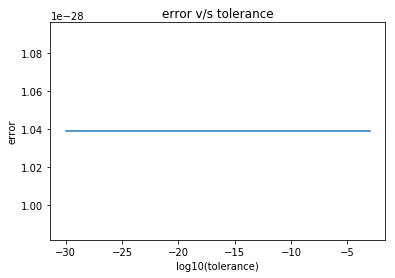

In [83]:
plt.figure()
plt.plot(np.log10(tolerances_to_try),errors)
plt.title('error v/s tolerance')
plt.xlabel("log10(tolerance)")
plt.ylabel("error")
plt.show()

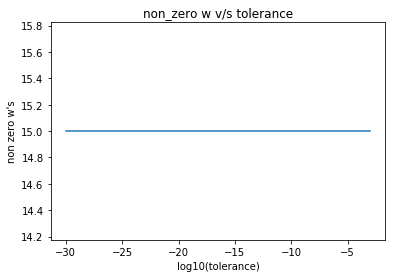

In [85]:
plt.figure()
plt.plot(np.log10(tolerances_to_try),non_zeros_tols)
plt.title('non_zero w v/s tolerance')
plt.xlabel("log10(tolerance)")
plt.ylabel("non zero w's")
plt.show()

### The above two plots indicate that the sparse weight determined from OMP is robust to even quite high values of tolerances.